# Updating Regional Timeseries for OISST Data


# Objective 1: Updating Regional Timeseries

New objectives on the "Update Timeseries" notebooks. 

Should the whole process be done: load all sst - > mask -> get timeseries -> subtract masked climatology?

Or just get the timeseries, and use the python marine heatwave function that matches heatwaveR?

Can we make everything generic, to take any list of names with paths to shapes?


In [1]:
# Load Packages
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import regionmask
import oisstools as ot
from datetime import date

# Set the workspace - local/ docker
box_root = ot.set_workspace("local")

# variable name to mask and make timeline from
var_name = "sst"

print(f"Working via directory: {box_root}")

Working via directory: /Users/akemberling/Box/


## Set the Update Period

In [2]:
# start and end years for the update
start_yr = 2021
end_yr   = 2021

print(f"Updating {start_yr} - {end_yr}")

Updating 2021 - 2021


## Select the Group of Regions to Update:

In [3]:
# Choose a set of regions to update (gmri_sst_focal_areas, lme, nmfs_trawl_regions)

# Option 1.
# update_regions = "gmri_sst_focal_areas"

# Option 2.
# update_regions = "lme"

# Option 3.
update_regions = "nmfs_trawl_regions"

# Option 4.
# update_regions = "nelme_regions"

print(f"Updating Timeseries for: {update_regions}")

Updating Timeseries for: nmfs_trawl_regions


### Get all their names using lookup catalog

In [4]:
# Get their names from lookup catalog
region_names = ot.get_region_names(region_group = update_regions)
print("Updating Timeseries for:")
for region in region_names:
    print(f" - {region}")

Updating Timeseries for:
 - georges_bank
 - gulf_of_maine
 - southern_new_england
 - mid_atlantic_bight
 - inuse_strata
 - regions_collection


### Get shapefile details using lookup function

In [5]:
# Get paths to each shapefile
mask_paths = ot.get_timeseries_paths(box_root = box_root, 
                                     region_list = region_names, 
                                     region_group = update_regions, 
                                     polygons = True)



# Use paths to make list of loaded polygons
mask_list = []
for mask_path_i in mask_paths:
    mask_shape = gpd.read_file(mask_path_i)
    mask_list.append(mask_shape)
    print(f"Loading Mask Area :  {mask_path_i}")

Loading Mask Area :  /Users/akemberling/Box/RES_Data/Shapefiles/nmfs_trawl_regions/nmfs_trawl_georges_bank.geojson
Loading Mask Area :  /Users/akemberling/Box/RES_Data/Shapefiles/nmfs_trawl_regions/nmfs_trawl_gulf_of_maine.geojson
Loading Mask Area :  /Users/akemberling/Box/RES_Data/Shapefiles/nmfs_trawl_regions/nmfs_trawl_southern_new_england.geojson
Loading Mask Area :  /Users/akemberling/Box/RES_Data/Shapefiles/nmfs_trawl_regions/nmfs_trawl_mid_atlantic_bight.geojson
Loading Mask Area :  /Users/akemberling/Box/RES_Data/Shapefiles/nmfs_trawl_regions/nmfs_trawl_inuse_strata.geojson
Loading Mask Area :  /Users/akemberling/Box/RES_Data/Shapefiles/nmfs_trawl_regions/nmfs_trawl_regions_collection.geojson


## Load the desired update years of OISSTv2 data
 
Use the load_box_oisst function to get the temperature data off of box for the period within the the start and end years of the update.

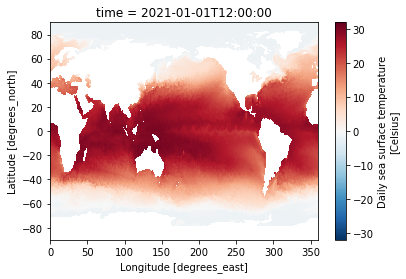

In [6]:
# Load OISSt using ot.load_box_oisst()
oisst_grid = ot.load_box_oisst(box_root, 
                               start_yr, 
                               end_yr, 
                               anomalies = False, 
                               do_parallel = True)
oisst_grid.sst.isel(time = 0).plot()

## Calculate Temp-timeseries for Update-period

In [7]:
# list to store the update period timeseries
new_ts = []

for mask_shp, mask_name in zip(mask_list, region_names):
    print(f"Processing {mask_name}")
    
    # Get masked timeseries
    masked_ts = ot.calc_ts_mask(grid_obj = oisst_grid, 
                                shp_obj = mask_shp, 
                                shp_name = mask_name,
                                var_name = var_name)
    
    # Add to list
    new_ts.append(masked_ts)

Processing georges_bank
Processing gulf_of_maine
Processing southern_new_england
Processing mid_atlantic_bight
Processing inuse_strata
Processing regions_collection


# Load existing LME timeseries to Update

Because these timelines have already been run for most years and only need an update, we can load the corresponding timelines and append on the new information.


### Get timeseries details using lookup function

In [8]:
# Get paths to each existing timeseries
mask_ts_paths = ot.get_timeseries_paths(box_root = box_root, 
                                        region_list = region_names, 
                                        region_group = update_regions, 
                                        polygons = False)


# Open existing time series to update them
ts_list = []
for mask_ts_path in mask_ts_paths:
    mask_ts = pd.read_csv(mask_ts_path)
    ts_list.append(mask_ts)
    print(f"Loading Timeseries : {mask_ts_path}")
    

Loading Timeseries : /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/nmfs_trawl_regions/OISSTv2_anom_georges_bank.csv
Loading Timeseries : /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/nmfs_trawl_regions/OISSTv2_anom_gulf_of_maine.csv
Loading Timeseries : /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/nmfs_trawl_regions/OISSTv2_anom_southern_new_england.csv
Loading Timeseries : /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/nmfs_trawl_regions/OISSTv2_anom_mid_atlantic_bight.csv
Loading Timeseries : /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/nmfs_trawl_regions/OISSTv2_anom_inuse_strata.csv
Loading Timeseries : /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/nmfs_trawl_regions/OISSTv2_anom_regions_collection.csv


# Append Updates to Existing Timeseries

Now that the update period has been processed we can append it onto what we already have to get a complete time series for SST.

In [9]:
# Step 4. match updates to existing timelines
complete_ts = []
for update_ts, old_ts in zip(new_ts, ts_list):
    # Append without overlap
    appended_ts = ot.append_sst_ts(old_ts = old_ts, update_ts = update_ts)
    complete_ts.append(appended_ts)

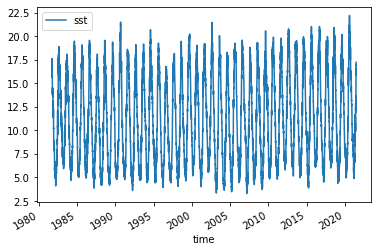

In [10]:
# Plot the first on to check
complete_ts[0].plot("time", "sst")

# Use Regional Climatology to Get Anomalies

We have tables with dates and temperature, and we have matching tables that contain the climate average for each day of year. Now we just need to pull that distinct information from the climatology, and join back using MOD.

In [13]:
# Step 4. match updates to existing timelines
anomaly_timeseries = []
for clim_ts, update_ts in zip(ts_list, complete_ts):
    # Append without overlap
    anomaly_ts = ot.rejoin_climatology(old_ts = clim_ts, new_ts = update_ts)
    anomaly_timeseries.append(anomaly_ts)

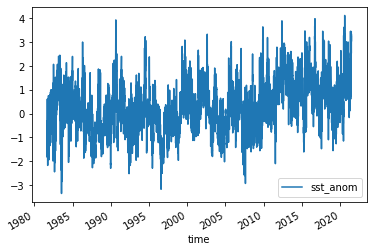

In [14]:
# See if Anomalies look fine
check_number = 0
anomaly_timeseries[check_number].plot("time", "sst_anom")

# # See if Anomalies look fine
# print(f"Timeseries Data for: {region_names[check_number]}")
# anomaly_timeseries[check_number].tail()

# Saving Updates

Once the timeseries have been checked they just need to be saved out again.

In [15]:
# Use the file paths we looked up before to set the save destinations
for updated_timeline_i, update_path_i in zip(anomaly_timeseries, mask_ts_paths):
    # save them
    print(f"Saving: {update_path_i}")
    updated_timeline_i.to_csv(update_path_i, index = False)

Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/nmfs_trawl_regions/OISSTv2_anom_georges_bank.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/nmfs_trawl_regions/OISSTv2_anom_gulf_of_maine.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/nmfs_trawl_regions/OISSTv2_anom_southern_new_england.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/nmfs_trawl_regions/OISSTv2_anom_mid_atlantic_bight.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/nmfs_trawl_regions/OISSTv2_anom_inuse_strata.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/nmfs_trawl_regions/OISSTv2_anom_regions_collection.csv
